In [168]:
%pylab
%matplotlib inline

from scipy.spatial import cKDTree as KDTree

import sys, os
sys.path.insert(0, '../kldivergence')
import kldivergence

sys.path.insert(0, os.path.expanduser('~/python/'))
import rmeutils

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [2]:
%load_ext watermark
%load_ext pycodestyle_magic

%watermark -v -i -g -iv

%load_ext autoreload
%autoreload 2

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.19.0

Git hash: 23a8f1654a9964ac6be1f7d79026a6365afed799

sys       : 3.8.5 (default, Sep  4 2020, 02:22:02) 
[Clang 10.0.0 ]
logging   : 0.5.1.2
matplotlib: 3.3.2
numpy     : 1.19.2
re        : 2.2.1
json      : 2.0.9



In [3]:
figsize(8,8)

In [202]:
from sklearn.mixture import GaussianMixture

gmm5 = GaussianMixture(n_components=5, 
                       covariance_type='spherical',
                       weights_init=asarray([0.25, 0.25, 0.16, 0.17, 0.17]),
                       means_init=asarray([[-0.3, 0.7],
                                      [0.4, 0.7],
                                      [1.0, 1.0],
                                      [-0.7, 0.3],
                                      [0.3, 0.3]]),
                       precisions_init=(1/0.03)*ones(5)
                      ).fit(asarray([[-0.3, 0.7],
                                      [0.4, 0.7],
                                      [1.0, 1.0],
                                      [-0.7, 0.3],
                                      [0.3, 0.3]]))
gmm5.means = asarray([[-0.3, 0.7],
                                      [0.4, 0.7],
                                      [1.0, 1.0],
                                      [-0.7, 0.3],
                                      [0.3, 0.3]])
gmm5.precisions = (1/0.03)*ones(5)
gmm5.weights = asarray([0.25, 0.25, 0.16, 0.17, 0.17])

In [208]:
def gmm5sample(N=1):
    """Draw samples from the GMM5 mixture model"""
    means = asarray([[-0.3, 0.7],
                     [0.4, 0.7],
                     [1.0, 1.0],
                     [-0.7, 0.3],
                     [0.3, 0.3]])
    covars = sqrt(0.03)*ones(5)
    weights = asarray([0.25, 0.25, 0.16, 0.17, 0.17])
    
    X = zeros((N,means.shape[1]))
    centre = np.random.choice(5, N, p=weights)
    for n in range(N):
        X[n,:] = randn(2)*covars[centre[n]] + means[centre[n]]
    return X


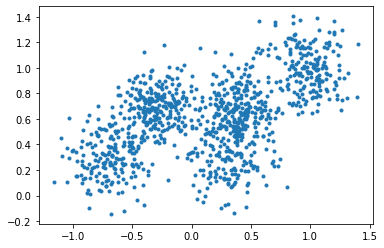

In [211]:
Z = gmm5sample(1000)
plot(*Z.T, '.')

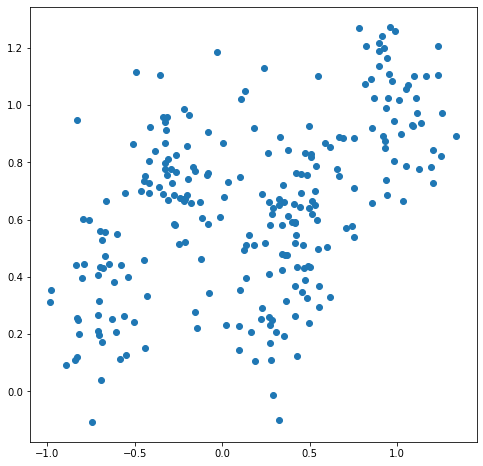

In [4]:
X = loadtxt('/Users/reverson/courses/ml/workshops/gmm5train.txt')
X = X[:,:2]
plot(*X.T, 'o')

In [214]:
def synthesise(X, M=None, sigma=0.1, resamples=1, repeats=1):
    """
    Generate synthetic data based on X
    
    Parameters
    ----------
    
    X : array_like, shape (N, D)
        Array of data to mimic.  Rows are D-dimensional observations.
        
    M : int
        Number of synthetic data to generate. Default N.
        
    sigma: float
        Standard deviation of \log(\gamma) factors.
        
    resamples: int
        Number of times to resample the direction to avoid collisions
        with the original data.
        
    repeats: int
        Number of times to repeat sampling to avoid collisions
        
    Returns
    -------
    
    Y : ndarray, shape (M, D)
        Synthetic data
    
    """
    N, D = X.shape

    if not M: M = N

    mu = log((N-1)/M)/D      # Mean of log gamma
    #print(f'{mu = :g}')
    
    Xtree = KDTree(X)

    r = Xtree.query(X, k=2, p=2)[0][:,1]  # Distances to each X's nearest neighbour

    Y = zeros((M,D))
    todo = list(range(M))

    for repeat in range(repeats):
        for m in todo:
            i = m if M == N else randint(N)

            sbest = 0
            for _ in range(resamples):
                n = random.randn(D)
                n /= norm(n)
                gamma = exp(randn(1)*sigma + mu)
                y = X[i] + gamma*r[i]*n
                # Check it's actually not too close to something else in X
                s = Xtree.query(y, k=1, p=2)[0]
                if s >= 0.9*R[i]*gamma:
                    break


            Y[m,:] = y

        Ytree = KDTree(Y)
        s, yneighbour = Ytree.query(X, k=1, p=2)
        # s/r < 1 means that a point in X is closer to a point in Y 
        # than its nearest neighbour in X.
        tooclose = s < 0.99*r
        todo = yneighbour[tooclose]
        #print(f'Todo: {len(todo)}', end='  ')
        #print(f'Closest: {min(s):.3g}', end='  ')
        #print(f'KL[X||Y]: {kldivergence.KLdivergence(X, Y):.3g}', end='  ')
        #print(f'KL[Xtest||Y]: {kldivergence.KLdivergence(Xtest, Y):.3g}')
        
    return Y

In [215]:
Y = synthesise(X, M=X.shape[0], resamples=10, repeats=20, sigma=0)

Text(0.5, 1.0, 'D(X, Y)')

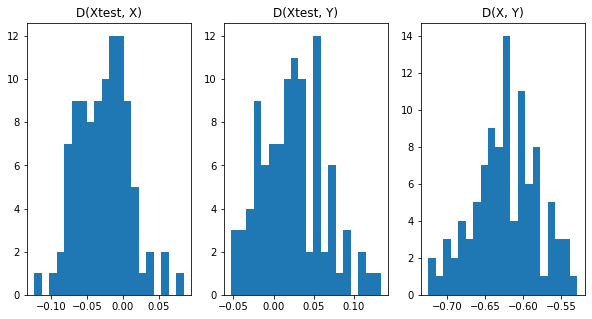

In [223]:
Xtest = gmm5sample(10000)

N = 250
M = 250
klXtest_X = []
klXtest_Y = []
klX_Y = []
for m in range(100):
    X = gmm5sample(N)
    Y = synthesise(X, M, sigma=0.4, resamples=51, repeats=1)
    klXtest_X.append(kldivergence.KLdivergence(Xtest, X))
    klXtest_Y.append(kldivergence.KLdivergence(Xtest, Y))
    klX_Y.append(kldivergence.KLdivergence(X, Y))
    
fig, ax = subplots(1, 3, figsize=(10, 5))
bins = 20
ax[0].hist(klXtest_X, bins=bins)
ax[0].set_title('D(Xtest, X)')
ax[1].hist(klXtest_Y, bins=bins)
ax[1].set_title('D(Xtest, Y)')
ax[2].hist(klX_Y, bins=bins)
ax[2].set_title('D(X, Y)')


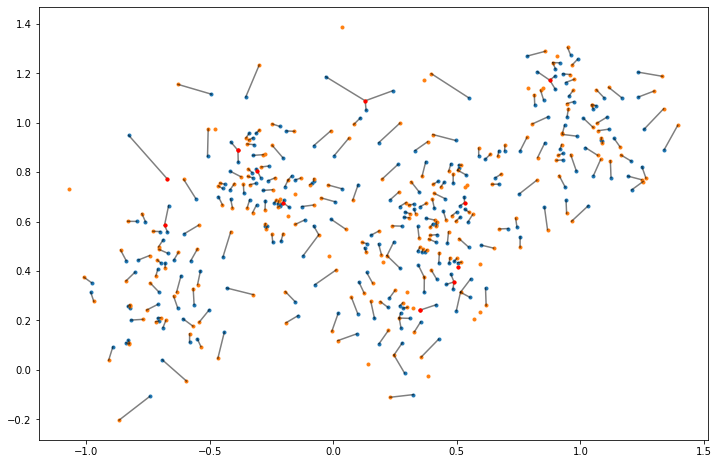

In [191]:
fig = figure(figsize=(12, 12))
plot(*X.T, '.')
plot(*Y.T, '.')
Ytree = KDTree(Y)
s, yneighbour = Ytree.query(X, k=1, p=2)
for n in range(X.shape[0]):
    if s[n] < r[n]:
        plot((X[n,0], Y[yneighbour[n],0]), 
             (X[n,1], Y[yneighbour[n],1]), 'k', alpha=0.5)
plot(*(Y[todo,:].T), 'r.')
axis('scaled');

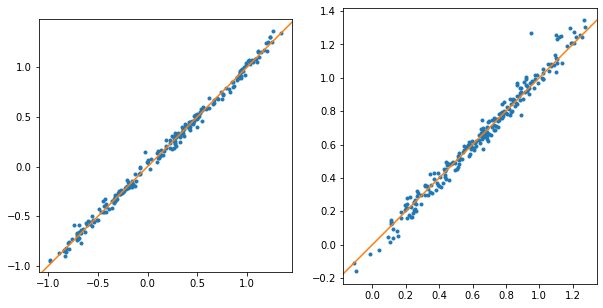

In [169]:
fig, ax = subplots(1, 2, figsize=(10, 10))
for i in range(2):
    ax[i].plot(X[:,i], Y[:,i], '.')
    ax[i].axis('scaled')
    rmeutils.draw_diagonal(ax[i])

In [154]:
kldivergence.KLdivergence(X, Y)

-0.19639488506892805

In [155]:
Xtest = loadtxt('/Users/reverson/courses/ml/workshops/gmm5test.txt')
Xtest = Xtest[:,:2]

kldivergence.KLdivergence(Xtest, X)

-0.09053756557642201

In [156]:
kldivergence.KLdivergence(Xtest, Y)

-0.10445727585477416

In [144]:
xtree = KDTree(X)
ytree = KDTree(Y)

r = xtree.query(X, k=2, p=2)[0][:,1]
s = ytree.query(X, k=1, p=2)[0]

figure()
hist(s/r, 100);